## Imports

In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import warnings
import zipfile

import bnlearn as bn
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import polars as pl
import requests
import s3fs
import seaborn as sns
import statsmodels.api as sm
from hydra import compose, core, initialize
from omegaconf import OmegaConf
from scipy.stats import chi2_contingency, norm
from scipy.stats.contingency import association
from statsmodels.api import Logit, add_constant

## Hydra Configurations

In [3]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="eda")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

hydra.initialize()

In [4]:
random_state = np.random.RandomState(config["random_seed"])

## Data

In [5]:
url = "https://github.com/CapitalOneRecruiting/DS/blob/master/transactions.zip?raw=true"
local_directory = "../data/raw"
local_file_path = os.path.join(local_directory, "transactions.zip")

os.makedirs(local_directory, exist_ok=True)

response = requests.get(url)
if response.status_code == 200:
    with open(local_file_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully to {local_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

30522086

File downloaded successfully to ../data/raw/transactions.zip


In [6]:
with zipfile.ZipFile(local_file_path, "r") as zip_file:
    zip_file.extractall(local_directory)
    print(f"File extracted to {local_directory}")

File extracted to ../data/raw


In [7]:
data = pl.read_ndjson(
    os.path.join(local_directory, "transactions.txt"), infer_schema_length=1000
)
print(f"The data set contains {len(data)} records and {len(data.columns)} columns")

The data set contains 786363 records and 29 columns


In [8]:
data.sample(10)

accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
str,str,f64,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,bool,str,str,bool,bool
"""574161833""","""574161833""",2500.0,2500.0,"""2016-07-02T18:57:49""",83.79,"""Dallas Journal""","""US""","""US""","""09""","""01""","""subscriptions""","""03/2029""","""2015-07-11""","""2015-07-11""","""461""","""461""","""7447""","""PURCHASE""","""""",0.0,"""""","""""","""""",false,"""""","""""",false,false
"""724518977""","""724518977""",20000.0,15388.03,"""2016-01-20T03:31:13""",68.16,"""ebay.com""","""US""","""US""","""05""","""01""","""online_retail""","""02/2023""","""2014-12-04""","""2016-01-04""","""339""","""339""","""5846""","""PURCHASE""","""""",4611.97,"""""","""""","""""",false,"""""","""""",false,false
"""708054411""","""708054411""",20000.0,7865.2,"""2016-12-23T13:09:34""",41.11,"""Raymour Flanigan""","""US""","""US""","""02""","""01""","""furniture""","""05/2025""","""2004-05-07""","""2016-10-04""","""895""","""895""","""9150""","""PURCHASE""","""""",12134.8,"""""","""""","""""",true,"""""","""""",false,false
"""380680241""","""380680241""",5000.0,3265.41,"""2016-02-18T02:54:21""",72.26,"""Fresh Flowers""","""US""","""US""","""09""","""01""","""online_gifts""","""04/2024""","""2014-06-21""","""2016-02-12""","""869""","""869""","""593""","""PURCHASE""","""""",1734.59,"""""","""""","""""",false,"""""","""""",false,true
"""453146753""","""453146753""",5000.0,4541.53,"""2016-01-13T20:16:10""",45.98,"""Blue Mountain eCards""","""US""","""US""","""02""","""01""","""online_gifts""","""01/2032""","""2015-01-16""","""2015-01-16""","""693""","""693""","""5897""","""PURCHASE""","""""",458.47,"""""","""""","""""",false,"""""","""""",false,false
"""133105237""","""133105237""",5000.0,498.9,"""2016-04-14T13:11:10""",9.99,"""Lyft""","""US""","""US""","""02""","""01""","""rideshare""","""02/2023""","""2015-12-23""","""2015-12-23""","""706""","""706""","""6220""","""PURCHASE""","""""",4501.1,"""""","""""","""""",false,"""""","""""",false,false
"""541202426""","""541202426""",250.0,222.78,"""2016-09-17T07:34:17""",99.29,"""Golds Gym #514764""","""US""","""US""","""05""","""01""","""health""","""11/2029""","""2014-09-17""","""2014-09-17""","""672""","""672""","""482""","""PURCHASE""","""""",27.22,"""""","""""","""""",false,"""""","""""",false,false
"""841351704""","""841351704""",50000.0,3820.83,"""2016-09-21T23:10:03""",130.02,"""Oklahoma City Times""","""US""","""US""","""02""","""01""","""subscriptions""","""06/2020""","""2015-12-17""","""2015-12-17""","""651""","""651""","""7831""","""PURCHASE""","""""",46179.17,"""""","""""","""""",true,"""""","""""",false,false
"""358749735""","""358749735""",15000.0,1109.93,"""2016-06-01T06:57:47""",181.03,"""In-N-Out #354119""","""US""","""US""","""05""","""08""","""fastfood""","""08/2021""","""2014-12-31""","""2014-12-31""","""649""","""649""","""6535""","""PURCHASE""","""""",13890.07,"""""","""""","""""",true,"""""","""""",false,false


### Sanity Checks

#### Data Types

In [9]:
dtypes_map = {col: data[col].dtype for col in data.columns}
dtypes_map

{'accountNumber': String,
 'customerId': String,
 'creditLimit': Float64,
 'availableMoney': Float64,
 'transactionDateTime': String,
 'transactionAmount': Float64,
 'merchantName': String,
 'acqCountry': String,
 'merchantCountryCode': String,
 'posEntryMode': String,
 'posConditionCode': String,
 'merchantCategoryCode': String,
 'currentExpDate': String,
 'accountOpenDate': String,
 'dateOfLastAddressChange': String,
 'cardCVV': String,
 'enteredCVV': String,
 'cardLast4Digits': String,
 'transactionType': String,
 'echoBuffer': String,
 'currentBalance': Float64,
 'merchantCity': String,
 'merchantState': String,
 'merchantZip': String,
 'cardPresent': Boolean,
 'posOnPremises': String,
 'recurringAuthInd': String,
 'expirationDateKeyInMatch': Boolean,
 'isFraud': Boolean}

#### Missing Values

In [10]:
# Convert all empty strings to Null if empty string across all string columns
data = data.with_columns(pl.col(pl.String).replace("", None))
data.null_count()

accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,4562,724,4054,409,0,0,0,0,0,0,0,698,786363,0,786363,786363,786363,0,786363,786363,0,0


<Axes: >

Text(0.5, 1.0, 'Column Nullities')

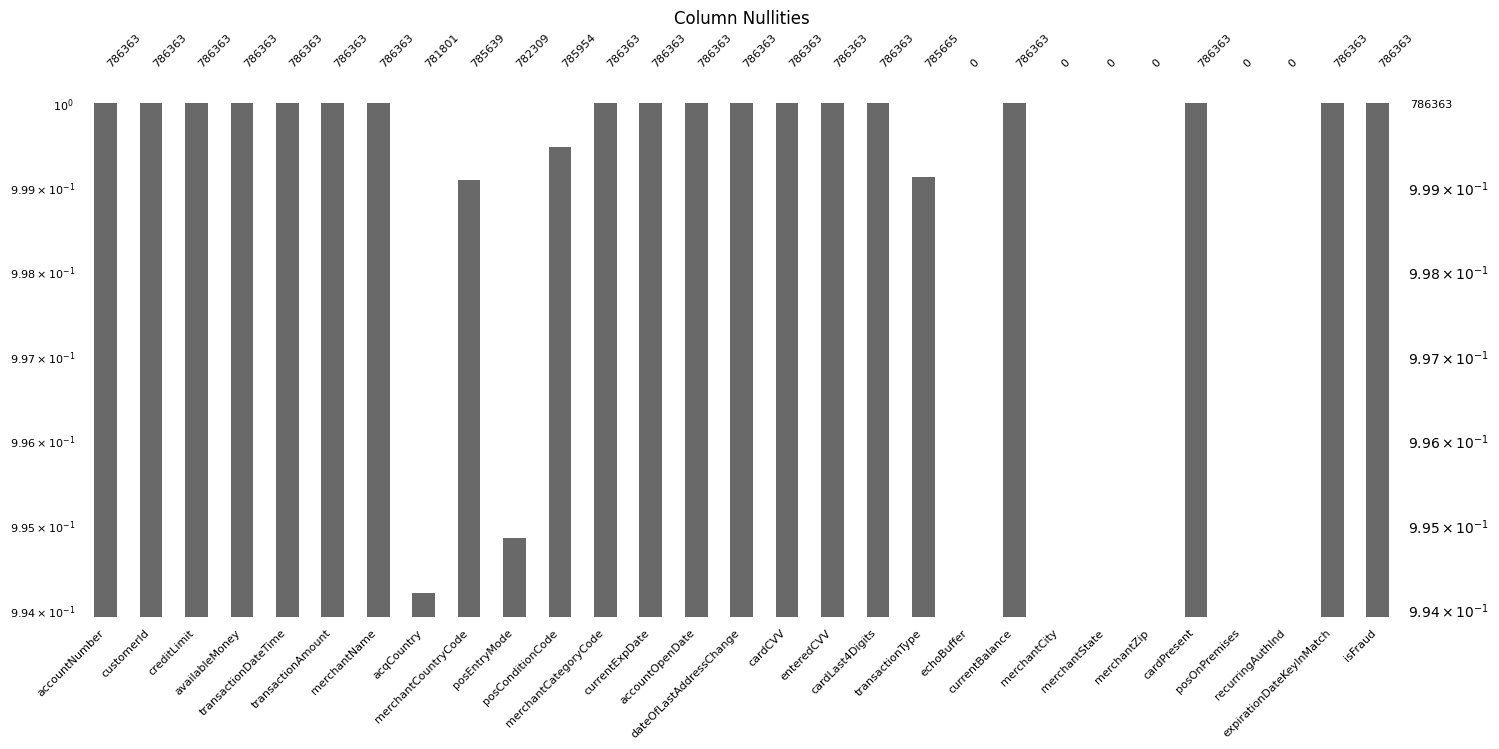

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=UserWarning)
    fig, ax = plt.subplots(figsize=(17, 7))
    msno.bar(data.to_pandas(), log=True, ax=ax, fontsize=8)
    ax.set_title("Column Nullities")

We will drop all columns that are **completely** empty. In actual work settings, I would investigate further, e.g., check upstream data sources and engineering team, to understand why these columns are empty.

In [12]:
data = data[
    [series.name for series in data if not (series.null_count() == data.height)]
]
data.shape

(786363, 23)

In [13]:
# Columns with missing values
{col: data[col].null_count() for col in data.columns if data[col].null_count() > 0}

{'acqCountry': 4562,
 'merchantCountryCode': 724,
 'posEntryMode': 4054,
 'posConditionCode': 409,
 'transactionType': 698}

### Data Type Conversions & Downcasting

Here we examine the data types of the columns:

- Find the max length in bytes for the string columns

- Find the max values for the numeric columns

- Sample some representative values for all the columns

This allows us to 1) understand the data a bit better and 2) identify any optimizations we can make to the data types. 

We start with profiling our data:

In [14]:
data_est_size_before = data.estimated_size(unit="mb")

data_est_size_before

136.22223949432373

For string columns, we will find the maximum length in bytes. This will help us understand the maximum memory usage for these columns.

In [15]:
# For each string column, find the value with the maximum length in bytes
data.select(
    [
        pl.col(column)
        .filter(pl.col(column).str.len_bytes() == pl.col(column).str.len_bytes().max())
        .first()
        .alias(f"max_bytes_{column}")
        for column in data.select(pl.selectors.string()).columns
    ]
)

max_bytes_accountNumber,max_bytes_customerId,max_bytes_transactionDateTime,max_bytes_merchantName,max_bytes_acqCountry,max_bytes_merchantCountryCode,max_bytes_posEntryMode,max_bytes_posConditionCode,max_bytes_merchantCategoryCode,max_bytes_currentExpDate,max_bytes_accountOpenDate,max_bytes_dateOfLastAddressChange,max_bytes_cardCVV,max_bytes_enteredCVV,max_bytes_cardLast4Digits,max_bytes_transactionType
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""737265056""","""737265056""","""2016-08-13T14:27:32""","""Dinosaur Sandwitch Bar #249717""","""CAN""","""CAN""","""02""","""01""","""online_subscriptions""","""06/2023""","""2015-03-14""","""2015-03-14""","""414""","""414""","""1803""","""ADDRESS_VERIFICATION"""


For numerical columns, we will find the maximum values. This will help us understand the largest value we need to store.

In [16]:
# For each numerical column, find the value with the maximum value
data.select(
    [
        pl.col(column).max().alias(f"max_{column}")
        for column in data.select(pl.selectors.numeric()).columns
    ]
)

max_creditLimit,max_availableMoney,max_transactionAmount,max_currentBalance
f64,f64,f64,f64
50000.0,50000.0,2011.54,47498.81


In [17]:
np.finfo(np.float64), np.finfo(np.float32)

(finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64),
 finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32))

In [18]:
# Find a representative non-missing value for each column
data.glimpse()

Rows: 786363
Columns: 23
$ accountNumber             <str> '737265056', '737265056', '737265056', '737265056', '830329091', '830329091', '830329091', '830329091', '830329091', '830329091'
$ customerId                <str> '737265056', '737265056', '737265056', '737265056', '830329091', '830329091', '830329091', '830329091', '830329091', '830329091'
$ creditLimit               <f64> 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0
$ availableMoney            <f64> 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 4990.63, 5000.0
$ transactionDateTime       <str> '2016-08-13T14:27:32', '2016-10-11T05:05:54', '2016-11-08T09:18:39', '2016-12-10T02:14:50', '2016-03-24T21:04:46', '2016-04-19T16:24:27', '2016-05-21T14:50:35', '2016-06-03T00:31:21', '2016-06-10T01:21:46', '2016-07-11T10:47:16'
$ transactionAmount         <f64> 98.55, 74.51, 7.47, 7.47, 71.18, 30.76, 57.28, 9.37, 523.67, 164.37
$ merchantName              <str> 'Uber', 'AMC #191138', 

In [19]:
schema = {
    # Id fields
    "accountNumber": pl.String,
    "customerId": pl.String,
    # Date and datetime fields
    "transactionDateTime": pl.Datetime(time_unit="ms"),
    "currentExpDate": pl.Date,
    "accountOpenDate": pl.Date,
    "dateOfLastAddressChange": pl.Date,
    # Numeric fields
    "creditLimit": pl.Float32,
    "availableMoney": pl.Float32,
    "transactionAmount": pl.Float32,
    "currentBalance": pl.Float32,
    # String or categorical fields
    "merchantName": pl.String,
    "acqCountry": pl.String,
    "merchantCountryCode": pl.String,
    "posEntryMode": pl.String,
    "posConditionCode": pl.String,
    "merchantCategoryCode": pl.String,
    "cardCVV": pl.String,
    "enteredCVV": pl.String,
    "cardLast4Digits": pl.String,
    "transactionType": pl.String,
    # Boolean fields
    "cardPresent": pl.Boolean,
    "expirationDateKeyInMatch": pl.Boolean,
    "isFraud": pl.Boolean,
}

# The expiration date format needs to be handled first
data = data.with_columns(
    pl.col("currentExpDate").str.to_date("%m/%Y").dt.month_end().alias("currentExpDate")
)
# Cast all columns
data = data.cast(schema)

{col: data[col].dtype for col in data.columns}

{'accountNumber': String,
 'customerId': String,
 'creditLimit': Float32,
 'availableMoney': Float32,
 'transactionDateTime': Datetime(time_unit='ms', time_zone=None),
 'transactionAmount': Float32,
 'merchantName': String,
 'acqCountry': String,
 'merchantCountryCode': String,
 'posEntryMode': String,
 'posConditionCode': String,
 'merchantCategoryCode': String,
 'currentExpDate': Date,
 'accountOpenDate': Date,
 'dateOfLastAddressChange': Date,
 'cardCVV': String,
 'enteredCVV': String,
 'cardLast4Digits': String,
 'transactionType': String,
 'currentBalance': Float32,
 'cardPresent': Boolean,
 'expirationDateKeyInMatch': Boolean,
 'isFraud': Boolean}

Examine the data size before and after downcasting:

In [20]:
data_est_size_after = data.estimated_size(unit="mb")

print(f"Estimated size before: {data_est_size_before:.4f} mb")
print(f"Estimated size after: {data_est_size_after:.4f} mb")

Estimated size before: 136.2222 mb
Estimated size after: 90.4763 mb


### Basic Statistics

In [21]:
num_cols = data.select(pl.selectors.numeric()).columns
str_cols = data.select(pl.selectors.string()).columns
dt_cols = data.select(pl.selectors.datetime() | pl.selectors.date()).columns
bool_cols = data.select(pl.selectors.boolean()).columns

assert set(data.columns) == set(num_cols + str_cols + dt_cols + bool_cols)

print(f"Numeric columns: {num_cols}")
print(f"String columns: {str_cols}")
print(f"Date and datetime columns: {dt_cols}")
print(f"Boolean columns: {bool_cols}")

Numeric columns: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
String columns: ['accountNumber', 'customerId', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType']
Date and datetime columns: ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
Boolean columns: ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']


#### Numeric Columns

In [22]:
data.select(num_cols).describe(percentiles=[0.25, 0.5, 0.75, 0.95])

statistic,creditLimit,availableMoney,transactionAmount,currentBalance
str,f64,f64,f64,f64
"""count""",786363.0,786363.0,786363.0,786363.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",10759.464844,6250.725586,136.985794,4508.739258
"""std""",11636.174805,8880.78418,147.725571,6457.441895
"""min""",250.0,-1005.630005,0.0,0.0
"""25%""",5000.0,1077.420044,33.650002,689.909973
"""50%""",7500.0,3184.860107,87.900002,2451.76001
"""75%""",15000.0,7500.0,191.479996,5291.100098
"""95%""",50000.0,19911.679688,433.350006,14600.389648


Text(0.5, 1.02, 'Pairplot of Numeric Columns')

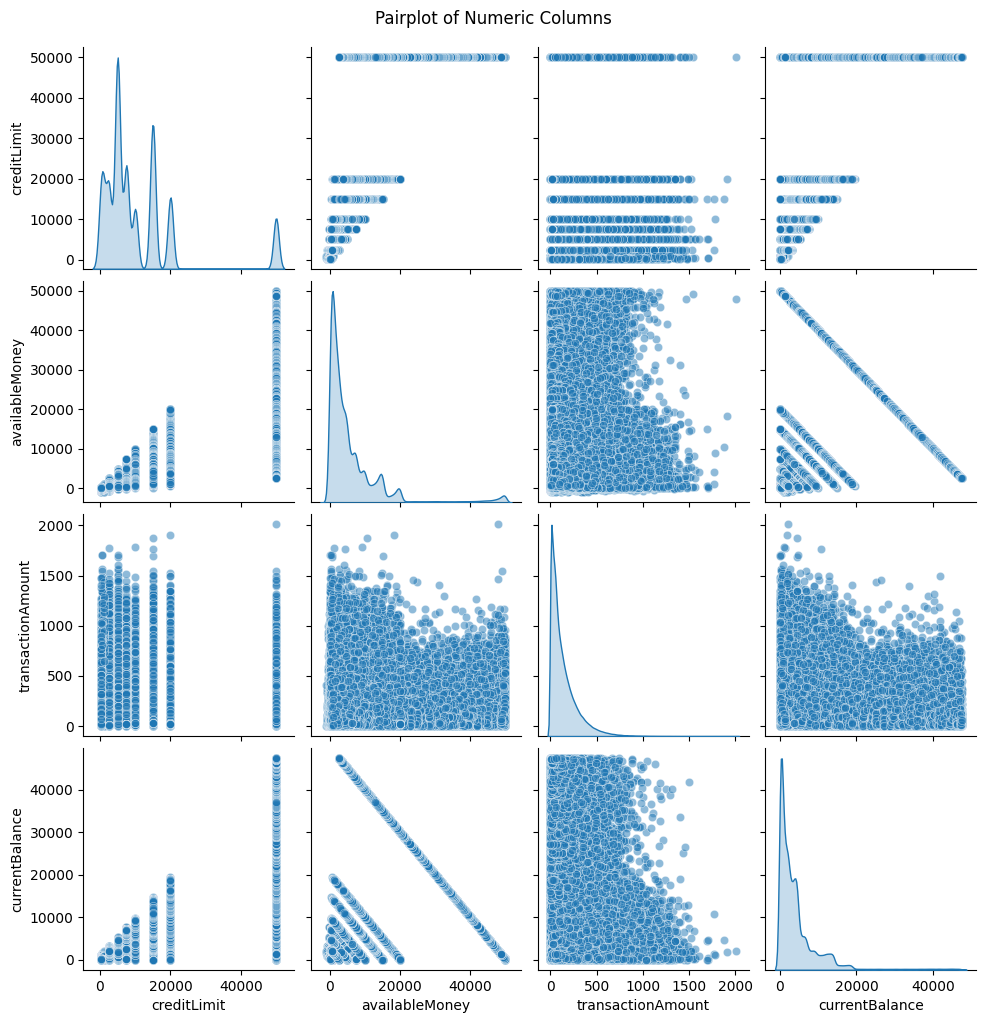

In [23]:
num_pairplot = sns.pairplot(
    data.select(num_cols).to_pandas(), diag_kind="kde", plot_kws={"alpha": 0.5}
)
num_pairplot.figure.suptitle("Pairplot of Numeric Columns", y=1.02)

#### String Columns

In [24]:
n_unique_str = data.select(
    [pl.col(col).n_unique().alias(f"n_unique_{col}") for col in str_cols]
)

n_unique_str_map = {col: n_unique_str[0, f"n_unique_{col}"] for col in str_cols}
n_unique_str_map = dict(
    sorted(
        n_unique_str_map.items(),
        key=lambda col_nunique_pair: col_nunique_pair[1],
        reverse=True,
    )
)
n_unique_str_map

{'cardLast4Digits': 5246,
 'accountNumber': 5000,
 'customerId': 5000,
 'merchantName': 2490,
 'enteredCVV': 976,
 'cardCVV': 899,
 'merchantCategoryCode': 19,
 'posEntryMode': 6,
 'acqCountry': 5,
 'merchantCountryCode': 5,
 'posConditionCode': 4,
 'transactionType': 4}

String columns with missing values, replace with "Unknown":

In [25]:
data = data.with_columns(
    [
        pl.col(col).fill_null("Unknown").alias(col)
        for col in str_cols
        if col not in ["accountNumber", "customerId"]
    ]
)

Quick inspection of the string columns with less than 10 unique values:

In [26]:
value_counts = {
    col: data[col].value_counts()
    for col in n_unique_str_map.keys()
    if n_unique_str_map[col] < 20
}

for col, vc in value_counts.items():
    print(f"Column: {col}")
    vc

Column: merchantCategoryCode


merchantCategoryCode,count
str,u32
"""auto""",21651
"""online_retail""",202156
"""subscriptions""",22901
"""food_delivery""",6000
"""mobileapps""",14990
…,…
"""online_subscriptions""",11067
"""airline""",15412
"""food""",75490


Column: posEntryMode


posEntryMode,count
str,u32
"""Unknown""",4054
"""80""",15283
"""09""",236481
"""05""",315035
"""02""",195934
"""90""",19576


Column: acqCountry


acqCountry,count
str,u32
"""Unknown""",4562
"""PR""",1538
"""US""",774709
"""MEX""",3130
"""CAN""",2424


Column: merchantCountryCode


merchantCountryCode,count
str,u32
"""US""",778511
"""Unknown""",724
"""MEX""",3143
"""CAN""",2426
"""PR""",1559


Column: posConditionCode


posConditionCode,count
str,u32
"""99""",7533
"""08""",149634
"""01""",628787
"""Unknown""",409


Column: transactionType


transactionType,count
str,u32
"""ADDRESS_VERIFICATION""",20169
"""Unknown""",698
"""PURCHASE""",745193
"""REVERSAL""",20303


For columns with high cardinality (many unique categories), compute the quantiles of the sorted unique values. These quantiles can help identify a cutoff point below which a category can be considered infrequent:

In [27]:
for col in n_unique_str_map:
    if n_unique_str_map[col] > 20 and col in data.columns:
        counts = data[col].value_counts().sort(by="count", descending=True)["count"]
        quantiles = {
            q: int(np.quantile(counts, q)) for q in [0.05, 0.25, 0.5, 0.75, 0.95]
        }
        print(f"Column: {col}: {quantiles}")

Column: cardLast4Digits: {0.05: 3, 0.25: 18, 0.5: 48, 0.75: 124, 0.95: 520}
Column: accountNumber: {0.05: 6, 0.25: 21, 0.5: 50, 0.75: 123, 0.95: 528}
Column: customerId: {0.05: 6, 0.25: 21, 0.5: 50, 0.75: 123, 0.95: 528}
Column: merchantName: {0.05: 23, 0.25: 43, 0.5: 95, 0.75: 117, 0.95: 832}
Column: enteredCVV: {0.05: 3, 0.25: 280, 0.5: 520, 0.75: 918, 0.95: 2291}
Column: cardCVV: {0.05: 132, 0.25: 328, 0.5: 556, 0.75: 977, 0.95: 2336}


Check if account numbers and customer IDs are identical:

In [28]:
data.select(
    (pl.col("accountNumber") == pl.col("customerId"))
    .all()
    .alias("accountNumber == customerId")
)

accountNumber == customerId
bool
true


#### Date and Datetime Columns

In [29]:
data.select([pl.col(col).min().alias(f"{col}_min") for col in dt_cols])

transactionDateTime_min,currentExpDate_min,accountOpenDate_min,dateOfLastAddressChange_min
datetime[ms],date,date,date
2016-01-01 00:01:02,2019-12-31,1989-08-22,1989-08-22


In [30]:
data.select([pl.col(col).max().alias(f"{col}_max") for col in dt_cols])

transactionDateTime_max,currentExpDate_max,accountOpenDate_max,dateOfLastAddressChange_max
datetime[ms],date,date,date
2016-12-30 23:59:45,2033-08-31,2015-12-31,2016-12-30


The max current expiration date seems to be 2033-08, which seems far out given we are in 2024.

In [31]:
data.filter(pl.col("currentExpDate").dt.year() == 2033).shape

data.filter(pl.col("currentExpDate").dt.year() == 2033)["isFraud"].value_counts(
    normalize=True
)

(35305, 23)

isFraud,proportion
bool,f64
true,0.016683
false,0.983317


In real production settings, I would investigate further, possibly check with relevant teams, e.g. data engineering and fraud detection experts, to understand why this may be the case. Is it a data quality issue or legitimate expiration dates?

#### Boolean Columns

In [32]:
for col in bool_cols:
    print(f"Column: {col}")
    data[col].value_counts(normalize=True)

Column: cardPresent


cardPresent,proportion
bool,f64
true,0.448734
false,0.551266


Column: expirationDateKeyInMatch


expirationDateKeyInMatch,proportion
bool,f64
true,0.001326
false,0.998674


Column: isFraud


isFraud,proportion
bool,f64
false,0.98421
true,0.01579


## Write Sanitized Data to S3

Drop the `customerId`, `merchantName`, and `cardLast4Digits` columns due to their high cardinality, as the cost of encoding them outweighs the potential benefits of retaining them:

- **`customerId`**: Customer IDs are exactly the same as account numbers, so we can drop this column.

- **`merchantName`**: While merchant names could provide valuable information—especially if external models are available to assess the riskiness of well-known or lesser-known merchants—additional data is required to unlock this potential.

- **`cardLast4Digits`**: The last four digits of the card number might be useful if there are existing blacklists or fraud databases that can flag risky cards. However, their utility depends on the availability of such resources.

In [ ]:
fs = s3fs.S3FileSystem(anon=False)
s3_key = f"s3://{config["s3_bucket"]}/data/sanitized"
with fs.open(os.path.join(s3_key, f"data.parquet"), "wb") as file:
    data.write_parquet(file)

## Transaction Amount 

### Histogram

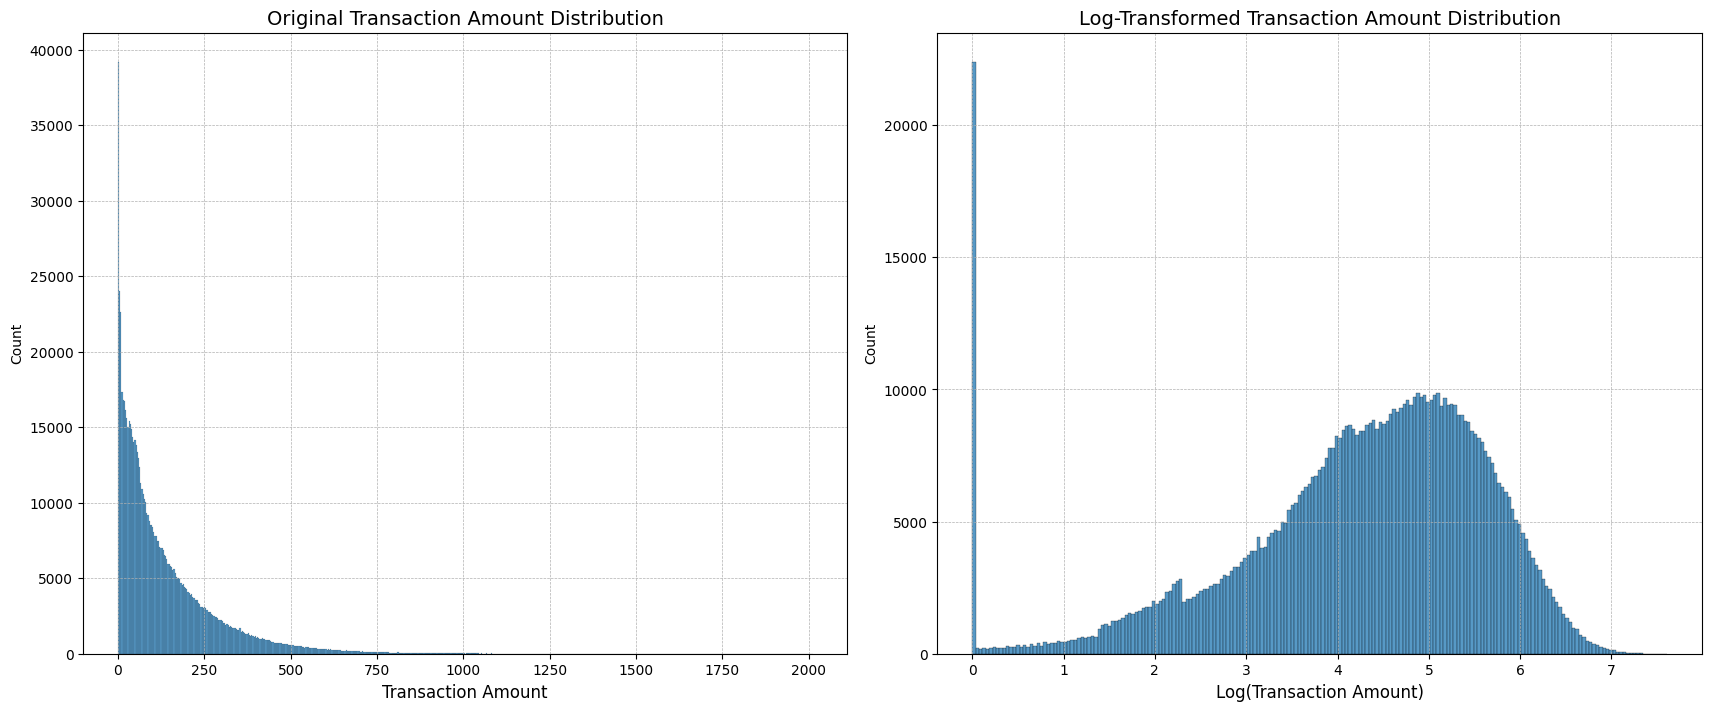

In [34]:
transaction_amount = data["transactionAmount"].to_numpy()
log_transaction_amount = np.log1p(transaction_amount)


fig, axes = plt.subplots(1, 2, figsize=(17, 7), constrained_layout=True)
# Original transaction amount
sns.histplot(
    transaction_amount,
    bins=np.histogram_bin_edges(transaction_amount, bins="auto"),
    ax=axes[0],
)
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)
axes[0].set_title("Original Transaction Amount Distribution", fontsize=14)
axes[0].set_xlabel("Transaction Amount", fontsize=12)
# Log-transformed transaction amount
sns.histplot(
    log_transaction_amount,
    bins=np.histogram_bin_edges(log_transaction_amount, bins="auto"),
    ax=axes[1],
)
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)
axes[1].set_title("Log-Transformed Transaction Amount Distribution", fontsize=14)
axes[1].set_xlabel("Log(Transaction Amount)", fontsize=12)
plt.show();

### Violin Plot

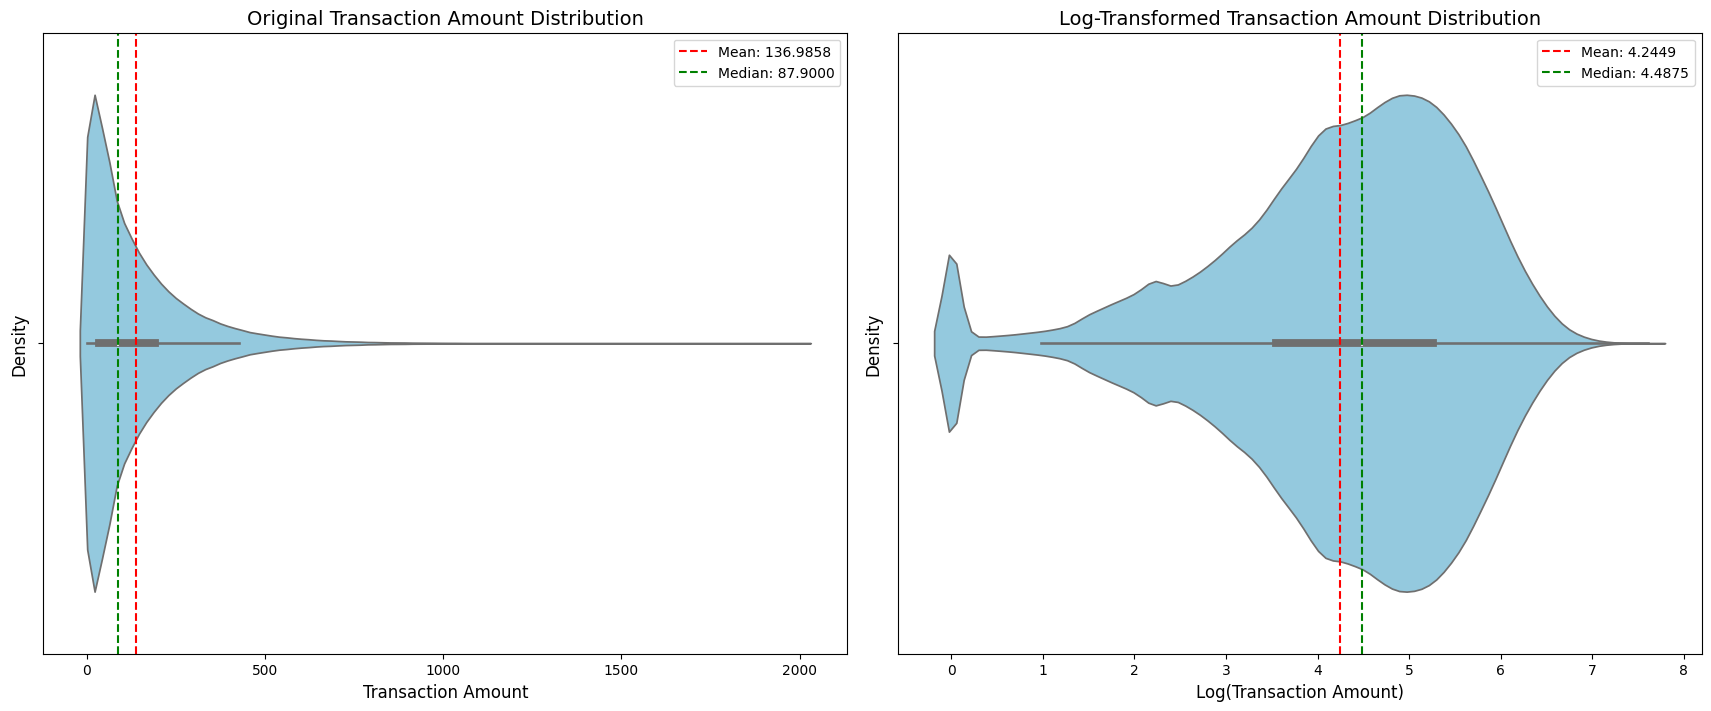

In [79]:
mean_value = np.mean(transaction_amount)
median_value = np.median(transaction_amount)
log_mean_value = np.mean(log_transaction_amount)
log_median_value = np.median(log_transaction_amount)

fig, axes = plt.subplots(1, 2, figsize=(17, 7), constrained_layout=True)
# Original transaction amount
sns.violinplot(x=transaction_amount, color="skyblue", ax=axes[0])
axes[0].axvline(
    mean_value, color="red", linestyle="--", label=f"Mean: {mean_value:.4f}"
)
axes[0].axvline(
    median_value, color="green", linestyle="--", label=f"Median: {median_value:.4f}"
)
axes[0].set_title("Original Transaction Amount Distribution", fontsize=14)
axes[0].set_xlabel("Transaction Amount", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend()
# Log-transformed transaction amount
sns.violinplot(x=log_transaction_amount, color="skyblue", ax=axes[1])
axes[1].axvline(
    log_mean_value, color="red", linestyle="--", label=f"Mean: {log_mean_value:.4f}"
)
axes[1].axvline(
    log_median_value,
    color="green",
    linestyle="--",
    label=f"Median: {log_median_value:.4f}",
)
axes[1].set_title("Log-Transformed Transaction Amount Distribution", fontsize=14)
axes[1].set_xlabel("Log(Transaction Amount)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend()
plt.show();

### Quantiles

In [80]:
data["transactionAmount"].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

statistic,value
str,f64
"""count""",786363.0
"""null_count""",0.0
"""mean""",136.985794
"""std""",147.725571
"""min""",0.0
"""25%""",33.650002
"""50%""",87.900002
"""75%""",191.479996
"""95%""",433.350006


The distribution of transaction amounts is a typical *pareto-like* right-skewed shape, with most transactions being smaller amounts.
   
   - The $95^{\text{th}}$ percentile is around 400 dollars, while the max transaction amount is around 2,000 dollars.

   - $50\%$ of the transactions are below 100 dollars.

### Hypothesis 1: Transaction Amounts and Fraud

**Hypothesis**: The likelihood of a transaction being fraudulent increases as the transaction amount increases.

The approach is as follows:

- Fit a simple logistic regression model with the binary target variable `isFraud` and the (log-transformed or raw) continuous feature `transactionAmount`.

- Examine the point estimator, i.e., the coefficient, on the `transactionAmount` feature and consider the right-tailed test for statistical significance.

#### Logistic Regression Model

In [81]:
y = np.int8(data["isFraud"])
X = add_constant(data["transactionAmount"], prepend=True)
logit_model = Logit(endog=y, exog=X, offset=None)
logit_results = logit_model.fit()

logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.079089
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               786363
Model:                          Logit   Df Residuals:                   786361
Method:                           MLE   Df Model:                            1
Date:                Sat, 21 Dec 2024   Pseudo R-squ.:                 0.02563
Time:                        01:15:22   Log-Likelihood:                -62193.
converged:                       True   LL-Null:                       -63829.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5864      0.013   -361.597      0.000      -4.611      -4.562
x1             0.0026   4.03e-05     64.904      0.000       0.003       0.003
==============================================================================
"""

##### Goodness of Fit (Deviance)

In [82]:
print(f"The likelihood ratio test statistic is {logit_results.llr:.4f}")
print(f"The p-value for the likelihood ratio test is {logit_results.llr_pvalue:.4f}")

The likelihood ratio test statistic is 3271.3788
The p-value for the likelihood ratio test is 0.0000


The test statistic (also know as the deviance) measures the deviation between the saturated model and the fitted model. The saturated model is a model that simply predicts the sample proportions for each class in the target variable. In this case, controlling type-I error rate at $\alpha = 0.05$, we reject the null hypothesis that the fitted model is a good fit. This suggests that the model is not adequate for the data as it does not improve upon the saturated model.

##### Model Diagnostics

If the logistic model is correct, then it follows asymptotically that:

$$
E[Y_{i} - \hat{\pi}_{i}] = E[e_{i}] = 0
$$

where $Y_{i}$ is the binary target variable, $\hat{\pi}_{i}$ is the predicted probability of the target variable, and $e_{i}$ is the residual.

Visually, the lowess curve of the deviance residuals on the linear predictors (i.e. before the logit transformation) should be approximately horizontal with a y-intercept of 0. Any deviation from this pattern may indicate a poor fit of the model.

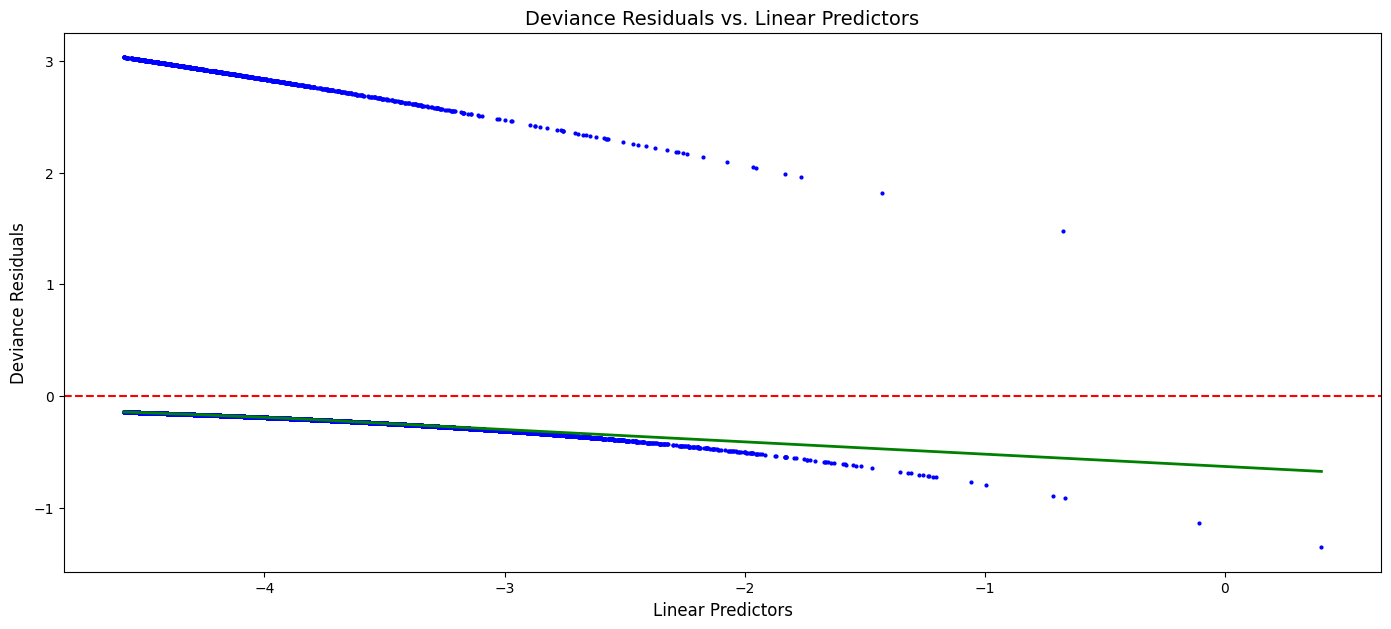

In [83]:
ax, fig = plt.subplots(figsize=(17, 7))
linear_predictors = logit_results.fittedvalues
dev_resid = logit_results.resid_dev
# Sample to reduce runtime
sample_idx = random_state.choice(np.arange(len(dev_resid)), size=50_000, replace=False)
# Lowess curve
lowess_smoothed = sm.nonparametric.lowess(
    dev_resid[sample_idx], linear_predictors[sample_idx]
)
plt.plot(
    linear_predictors[sample_idx],
    dev_resid[sample_idx],
    "o",
    markersize=2,
    color="blue",
)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="green", linewidth=2)
plt.axhline(0, color="red", linestyle="--")
plt.title("Deviance Residuals vs. Linear Predictors", fontsize=14)
plt.xlabel("Linear Predictors", fontsize=12)
plt.ylabel("Deviance Residuals", fontsize=12)
plt.show();

#### Inference on Point Estimator

**Null Hypothesis**: The point estimator on `transactionAmount` is less than or equal to zero.

**Alternative Hypothesis**: The point estimator on `transactionAmount` is greater than zero.

In [84]:
beta_hat_transaction_amount = logit_results.params[1]
se_beta_hat_transaction_amount = logit_results.bse[1]
z_stat_transaction_amount = beta_hat_transaction_amount / se_beta_hat_transaction_amount

# Right-tailed test
p_value_transaction_amount = 1 - norm.cdf(z_stat_transaction_amount)
print(f"The z-statistic for the transaction amount is {z_stat_transaction_amount:.4f}")
print(f"The p-value for the transaction amount is {p_value_transaction_amount:.4f}")

The z-statistic for the transaction amount is 64.9043
The p-value for the transaction amount is 0.0000


**A frequentist interpretation of the p-value**: controlling type-I error rate at $\alpha=0.05$, the probability of observing a test statistic as extreme as the one observed, given that the null hypothesis is true, is less than 0.05; therefore, we reject the null hypothesis in favor of the alternative hypothesis.

**Business Interpretation**: The odds ratio is obtained by exponentiating the coefficient:

$$
\text { Odds Ratio }=e^{0.0026} \approx 1.0026
$$

This indicates that for each one-dollar increase in transaction amount, the odds of a transaction being fraud increase by approximately $0.26\%$. 

To quantify this result further, we can use the following formula to calculate the amount of increase in transaction amount that would double the odds of a transaction being fraudulent:

$$
\text{Odds Ratio} = e^{\beta \cdot \Delta x}
$$

Taking the natural logarithm of both sides:

$$
\begin{align*}
\ln(\text{Odds Ratio}) &= \beta \cdot \Delta x \\
\ln(2) &= \cancel{\ln(e)}^{\beta \cdot \Delta x} \\
\ln(2)&= \beta \cdot \Delta x \\ 
\Delta x &= \frac{\ln(2)}{\beta}
\end{align*}
$$


In [85]:
odds_ratio_of_interest = 2
delta_x_required = float(np.log(odds_ratio_of_interest) / beta_hat_transaction_amount)
delta_x_required

264.71496908761213

In [86]:
iqr_transaction_amount = np.percentile(data["transactionAmount"], 75) - np.percentile(
    data["transactionAmount"], 25
)
relative_to_iqr = float(delta_x_required / iqr_transaction_amount) * 100
relative_to_iqr

167.72159337997437

For context, a approximate $\$264.71$ increase in transaction amount doubles the odds of fraud, which is approximately $167.72\%$ of the IQR of the transaction amount feature. This indicates that the increase needed to double the odds of fraud is significantly larger than the typical spread of transaction amounts in the middle 50% of the data.

**Model Fit:** Here, the simple logistic regression model does not adequately capture the relationship between transaction amount and fraud. This is expected, given the complexity of interactions among multiple contributing factors. As such, the statistical significance of the `transactionAmount` coefficient should be interpreted cautiously and not taken at face value.

### Hypothesis 2: Card Present and Fraud

Another statistically testable hypothesis is the statistical relation between `cardPresent` and `isFraud`.

#### Hypothesis and Methodology

**Null Hypothesis**: The binary variable `isFraud` (fraudulent or not) is independent of the binary variable `cardPresent` (card physically present or not).

**Alternative Hypothesis**: The binary variable `isFraud` is related to the binary variable `cardPresent`.

The approach is as follows:

1. Construct a contingency table for `cardPresent` and `isFraud`.
2. Perform a **chi-square test of independence** to evaluate the relationship between the two binary variables.
3. Calculate **Cramér's V** to quantify the effect size.

In [87]:
cross_tab = (
    data.select(pl.col(["isFraud", "cardPresent"]))
    .group_by(["isFraud", "cardPresent"])
    .len()
    .pivot(values="len", index="isFraud", on="cardPresent")
    .select(pl.col(["false", "true"]))
    .to_numpy()
)

chi2_res = chi2_contingency(
    observed=cross_tab, correction=True, lambda_="log-likelihood"
)

cross_tab
print(f"The chi-squared test statistic is {chi2_res.statistic:.4f}")
print(f"The p-value for the chi-squared test is {chi2_res.pvalue:.4f}")

array([[424533, 349413],
       [  8962,   3455]], dtype=uint32)

The chi-squared test statistic is 1550.1098
The p-value for the chi-squared test is 0.0000


Controlling type-I error rate at $\alpha=0.05$, we reject the null hypothesis in favor of the alternative hypothesis and conclude **that `isFraud` and `cardPresent` are statistically dependent**.

Given the statistically significance, we can further quantify the level of association between `cardPresent` and `isFraud` using Cramér's V, which ranges from 0 to 1. A value of 0 indicates no association, while a value of 1 indicates a perfect association.

In [88]:
cramers_v = association(
    observed=cross_tab, method="cramer", correction=True, lambda_="log-likelihood"
)
print(f"The Cramer's V statistic is {cramers_v:.4f}")

The Cramer's V statistic is 0.0444


Effect Size:

- Cramér's V: 0.0444 (small effect size)
- The relationship is statistically significant but the association is small in magnitude.

## Duplicate Transactions

* **Reversed Transactions**: Reversed transactions are identified as those marked as reversals that match the amount, merchant name, and merchant category code of a prior purchase.

* **Multi-Swipe Transactions**: Multi-swipe transactions occur when consecutive purchases have the same amount, merchant name, and merchant category code, and are processed within a 10-minute window.

In [89]:
# Select the relevant columns
transaction_data = data.select(
    [
        "accountNumber",
        "transactionAmount",
        "transactionType",
        "transactionDateTime",
        "merchantName",
        "merchantCategoryCode",
        "cardPresent",
        "expirationDateKeyInMatch",
        "isFraud",
    ]
)
transaction_data.head()

accountNumber,transactionAmount,transactionType,transactionDateTime,merchantName,merchantCategoryCode,cardPresent,expirationDateKeyInMatch,isFraud
str,f32,str,datetime[ms],str,str,bool,bool,bool
"""737265056""",98.550003,"""PURCHASE""",2016-08-13 14:27:32,"""Uber""","""rideshare""",false,false,false
"""737265056""",74.510002,"""PURCHASE""",2016-10-11 05:05:54,"""AMC #191138""","""entertainment""",true,false,false
"""737265056""",7.47,"""PURCHASE""",2016-11-08 09:18:39,"""Play Store""","""mobileapps""",false,false,false
"""737265056""",7.47,"""PURCHASE""",2016-12-10 02:14:50,"""Play Store""","""mobileapps""",false,false,false
"""830329091""",71.18,"""PURCHASE""",2016-03-24 21:04:46,"""Tim Hortons #947751""","""fastfood""",true,false,false


Consistency in Merchant Details and Timing: Reversed and multi-swipe transactions are assumed to involve the same merchant name, merchant category code, and identical transaction amounts. Additionally, a 10-minute window is used to define multi-swipe transactions. 

* Transactions that appear duplicated within the first few minutes after an initial transaction can be reasonably attributed to accidentally (additional) swipes during a single payment attempt.

* Transactions with time gaps up to 10 minutes from the initial transaction may account for scenarios where the payment system or vendor retries a transaction following an initial failure.

In [90]:
multi_swipe_time_window = pl.duration(minutes=10)
multi_swipe_time_window

<Expr ['10m.alias("duration")'] at 0x3BFD3F0B0>

### Reversed & Multi-Swipe Transaction Amounts and Occurrences

We use `shift(n=1)` here to mimic the `LAG` function in SQL, which allows us to compare the current transaction with the previous transaction within the same account.

In [91]:
transaction_data = (
    transaction_data.filter(pl.col("transactionType").is_in(["PURCHASE", "REVERSAL"]))
    .with_columns(
        pl.all(),
        # Lagged transaction type
        pl.col("transactionType")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionType"),
        # Lagged transaction amount
        pl.col("transactionAmount")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionAmount"),
        # Lagged transaction datetime
        pl.col("transactionDateTime")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionDateTime"),
        # Lagged merchant name
        pl.col("merchantName")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevMerchantName"),
        # Lagged merchant category code
        pl.col("merchantCategoryCode")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevMerchantCategoryCode"),
    )
    .sort(pl.col(["accountNumber", "transactionDateTime"]))
)

transaction_data

accountNumber,transactionAmount,transactionType,transactionDateTime,merchantName,merchantCategoryCode,cardPresent,expirationDateKeyInMatch,isFraud,prevTransactionType,prevTransactionAmount,prevTransactionDateTime,prevMerchantName,prevMerchantCategoryCode
str,f32,str,datetime[ms],str,str,bool,bool,bool,str,f32,datetime[ms],str,str
"""100088067""",205.130005,"""PURCHASE""",2016-01-12 00:59:52,"""EZ Putt Putt #982199""","""entertainment""",true,false,false,null,null,null,null,null
"""100088067""",46.43,"""PURCHASE""",2016-01-12 19:49:41,"""Dinosaur Sandwitch Bar #303701""","""food""",true,false,false,"""PURCHASE""",205.130005,2016-01-12 00:59:52,"""EZ Putt Putt #982199""","""entertainment"""
"""100088067""",378.670013,"""PURCHASE""",2016-01-17 15:41:46,"""Mobile eCards""","""online_gifts""",false,false,false,"""PURCHASE""",46.43,2016-01-12 19:49:41,"""Dinosaur Sandwitch Bar #303701""","""food"""
"""100088067""",66.07,"""PURCHASE""",2016-02-02 19:57:18,"""EZ Putt Putt #40513""","""entertainment""",true,false,false,"""PURCHASE""",378.670013,2016-01-17 15:41:46,"""Mobile eCards""","""online_gifts"""
"""100088067""",141.600006,"""PURCHASE""",2016-02-03 04:48:54,"""34th BBQ #412895""","""food""",true,false,false,"""PURCHASE""",66.07,2016-02-02 19:57:18,"""EZ Putt Putt #40513""","""entertainment"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""999389635""",267.619995,"""PURCHASE""",2016-09-16 15:35:24,"""Franks Pub #680641""","""food""",true,false,false,"""PURCHASE""",4.62,2016-08-22 11:42:48,"""Play Store""","""mobileapps"""
"""999389635""",4.62,"""PURCHASE""",2016-09-22 13:58:30,"""Play Store""","""mobileapps""",false,false,false,"""PURCHASE""",267.619995,2016-09-16 15:35:24,"""Franks Pub #680641""","""food"""
"""999389635""",4.62,"""PURCHASE""",2016-10-23 16:47:41,"""Play Store""","""mobileapps""",false,false,false,"""PURCHASE""",4.62,2016-09-22 13:58:30,"""Play Store""","""mobileapps"""


Identification of reversed transactions:

- Current transaction is a reversal
- Previous transaction is a purchase
- The amount of the current transaction is the same as the previous transaction
- The merchant name and merchant category code are the same as the previous transaction

In [92]:
transaction_data = transaction_data.with_columns(
    (
        (pl.col("transactionType") == "REVERSAL")
        & (pl.col("prevTransactionType") == "PURCHASE")
        & (pl.col("prevTransactionAmount") == pl.col("transactionAmount"))
        & (pl.col("prevMerchantName") == pl.col("merchantName"))
        & (pl.col("prevMerchantCategoryCode") == pl.col("merchantCategoryCode"))
    ).alias("isReversal")
)

transaction_data.filter(pl.col("isReversal")).head(5)

accountNumber,transactionAmount,transactionType,transactionDateTime,merchantName,merchantCategoryCode,cardPresent,expirationDateKeyInMatch,isFraud,prevTransactionType,prevTransactionAmount,prevTransactionDateTime,prevMerchantName,prevMerchantCategoryCode,isReversal
str,f32,str,datetime[ms],str,str,bool,bool,bool,str,f32,datetime[ms],str,str,bool
"""100088067""",22.32,"""REVERSAL""",2016-11-20 08:00:04,"""AMC #79863""","""entertainment""",true,false,false,"""PURCHASE""",22.32,2016-11-20 07:57:05,"""AMC #79863""","""entertainment""",true
"""100328049""",43.740002,"""REVERSAL""",2016-01-15 20:36:18,"""Lyft""","""rideshare""",false,false,false,"""PURCHASE""",43.740002,2016-01-15 20:34:35,"""Lyft""","""rideshare""",true
"""100328049""",284.970001,"""REVERSAL""",2016-03-26 17:35:09,"""McDonalds #423357""","""fastfood""",true,false,false,"""PURCHASE""",284.970001,2016-03-24 22:57:15,"""McDonalds #423357""","""fastfood""",true
"""101376441""",96.629997,"""REVERSAL""",2016-07-12 00:44:32,"""target.com""","""online_retail""",false,false,false,"""PURCHASE""",96.629997,2016-07-05 15:03:41,"""target.com""","""online_retail""",true
"""101596991""",294.01001,"""REVERSAL""",2016-12-30 19:50:06,"""Franks Sandwitch Bar""","""food""",true,false,false,"""PURCHASE""",294.01001,2016-12-30 19:49:59,"""Franks Sandwitch Bar""","""food""",true


Identification of multi-swipe transactions:

- Current transaction is a purchase
- Previous transaction is a purchase
- The amount of the current transaction is the same as the previous transaction
- The merchant name and merchant category code are the same as the previous transaction
- The time elapsed between the current and previous transaction is less than 10 minutes

In [93]:
transaction_data = transaction_data.with_columns(
    (
        (pl.col("transactionType") == "PURCHASE")
        & (pl.col("prevTransactionType") == "PURCHASE")
        & (pl.col("transactionAmount") == pl.col("prevTransactionAmount"))
        & (pl.col("merchantName") == pl.col("prevMerchantName"))
        & (pl.col("merchantCategoryCode") == pl.col("prevMerchantCategoryCode"))
        & (
            (pl.col("transactionDateTime") - pl.col("prevTransactionDateTime"))
            <= multi_swipe_time_window
        )
    ).alias("isMultiSwipe"),
    # The difference between two datetime columns is a duration series
    (pl.col("transactionDateTime") - pl.col("prevTransactionDateTime")).alias(
        "durationSinceLastTransaction"
    ),
)

transaction_data.filter(pl.col("isMultiSwipe")).sort(
    pl.col("accountNumber", "transactionDateTime")
).head(5)

accountNumber,transactionAmount,transactionType,transactionDateTime,merchantName,merchantCategoryCode,cardPresent,expirationDateKeyInMatch,isFraud,prevTransactionType,prevTransactionAmount,prevTransactionDateTime,prevMerchantName,prevMerchantCategoryCode,isReversal,isMultiSwipe,durationSinceLastTransaction
str,f32,str,datetime[ms],str,str,bool,bool,bool,str,f32,datetime[ms],str,str,bool,bool,duration[ms]
"""100088067""",411.350006,"""PURCHASE""",2016-10-16 18:01:02,"""Fresh Flowers""","""online_gifts""",false,false,false,"""PURCHASE""",411.350006,2016-10-16 18:01:00,"""Fresh Flowers""","""online_gifts""",false,true,2s
"""100737756""",693.5,"""PURCHASE""",2016-01-18 01:55:28,"""Franks Deli""","""food""",true,false,false,"""PURCHASE""",693.5,2016-01-18 01:55:24,"""Franks Deli""","""food""",false,true,4s
"""100737756""",693.5,"""PURCHASE""",2016-01-18 01:58:26,"""Franks Deli""","""food""",true,false,false,"""PURCHASE""",693.5,2016-01-18 01:55:28,"""Franks Deli""","""food""",false,true,2m 58s
"""100737756""",211.220001,"""PURCHASE""",2016-07-02 12:07:00,"""South Steakhouse #73819""","""food""",true,false,false,"""PURCHASE""",211.220001,2016-07-02 12:05:04,"""South Steakhouse #73819""","""food""",false,true,1m 56s
"""100737756""",43.25,"""PURCHASE""",2016-07-10 14:32:06,"""34th BBQ #166379""","""food""",true,false,false,"""PURCHASE""",43.25,2016-07-10 14:31:07,"""34th BBQ #166379""","""food""",false,true,59s


By definition, since we always anchor on the current transaction and look back at the previous transaction, the first of a sequence of seemingly duplicated transactions will never be flagged as either a reversed or multi-swipe transaction.

In [94]:
with pl.Config(thousands_separator=True, float_precision=4):
    (
        transaction_data.select(
            # Sum the true values to get the count
            pl.col("isReversal").sum().alias("countReversed"),
            pl.col("isMultiSwipe").sum().alias("countMultiSwipes"),
            # Sum the conditional transaction amounts
            pl.when(pl.col("isReversal"))
            .then(pl.col("transactionAmount"))
            .otherwise(0)
            .sum()
            .alias("totalReversedAmount"),
            pl.when(pl.col("isMultiSwipe"))
            .then(pl.col("transactionAmount"))
            .otherwise(0)
            .sum()
            .alias("totalMultiSwipeAmount"),
        )
    )

countReversed,countMultiSwipes,totalReversedAmount,totalMultiSwipeAmount
u32,u32,f32,f32
"6,079","7,338","909,910.2500","1,085,643.1250"


#### Sensitivity Analysis

A sensitivity test removing the requirement for matching merchant names and categories can be used to test if the additional checks are unnecessary for this dataset. 

In [95]:
# Create a separate data frame for the transaction data sensitivity analysis
transaction_data_sensitivity = data.select(
    [
        "accountNumber",
        "transactionAmount",
        "transactionType",
        "transactionDateTime",
        "merchantName",
        "merchantCategoryCode",
    ]
)
# Lagged transaction type
transaction_data_sensitivity = (
    transaction_data_sensitivity.filter(
        pl.col("transactionType").is_in(["PURCHASE", "REVERSAL"])
    )
    .with_columns(
        pl.all(),
        # Lagged transaction type
        pl.col("transactionType")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionType"),
        # Lagged transaction amount
        pl.col("transactionAmount")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionAmount"),
        # Lagged transaction datetime
        pl.col("transactionDateTime")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevTransactionDateTime"),
        # Lagged merchant name
        pl.col("merchantName")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevMerchantName"),
        # Lagged merchant category code
        pl.col("merchantCategoryCode")
        .sort_by(by="transactionDateTime", descending=False)
        .shift(n=1)
        .over("accountNumber")
        .alias("prevMerchantCategoryCode"),
    )
    .sort(pl.col(["accountNumber", "transactionDateTime"]))
)
# Reversed transactions
transaction_data_sensitivity = transaction_data_sensitivity.with_columns(
    (
        (pl.col("transactionType") == "REVERSAL")
        & (pl.col("prevTransactionType") == "PURCHASE")
        & (pl.col("prevTransactionAmount") == pl.col("transactionAmount"))
    ).alias("isReversal")
)
# Multi-swipe transactions
transaction_data_sensitivity = transaction_data_sensitivity.with_columns(
    (
        (pl.col("transactionType") == "PURCHASE")
        & (pl.col("prevTransactionType") == "PURCHASE")
        & (pl.col("transactionAmount") == pl.col("prevTransactionAmount"))
        & (
            (pl.col("transactionDateTime") - pl.col("prevTransactionDateTime"))
            <= multi_swipe_time_window
        )
    ).alias("isMultiSwipe"),
)

with pl.Config(thousands_separator=True, float_precision=4):
    (
        transaction_data_sensitivity.select(
            # Sum the true values to get the count
            pl.col("isReversal").sum().alias("countReversed"),
            pl.col("isMultiSwipe").sum().alias("countMultiSwipes"),
            # Sum the conditional transaction amounts
            pl.when(pl.col("isReversal"))
            .then(pl.col("transactionAmount"))
            .otherwise(0)
            .sum()
            .alias("totalReversedAmount"),
            pl.when(pl.col("isMultiSwipe"))
            .then(pl.col("transactionAmount"))
            .otherwise(0)
            .sum()
            .alias("totalMultiSwipeAmount"),
        )
    )

countReversed,countMultiSwipes,totalReversedAmount,totalMultiSwipeAmount
u32,u32,f32,f32
"6,080","7,338","909,985.3125","1,085,643.1250"


As can be seen, removing the merchant name and category code checks yields the same results for both reversed and multi-swipe transactions. This suggests that the additional checks for merchant name and category code may not be necessary for this dataset.

However, in practice, I would collaborate with stakeholders to assess the likelihood of identical transaction amounts across different merchants to better align criteria with real-world processes.

## Understanding Reversed, Multi-Swipe, and Fraudulent Transactions

Since we created two binary columns `isReversed` and `isMultiSwipe`, we can now investigate the relationship between these columns and the target variable `isFraud`. One interesting technique that can be used here is probabilistic inference. Specifically, we can conduct the analysis using a Bayesian Network model. Here are some justifications for this approach:

1. All features are binary, which can be thought of as realizations of Bernoulli random variables, making Bayesian inference a natural fit for modeling their relationships.

2. Bayesian modeling goes beyond correlations, enabling probabilistic insights like the likelihood of fraud given specific evidence (e.g., a reversed or multi-swipe transaction).

Because we are primarily interested in understanding how the other features are related to `isFraud`, we will assume following structure for the graph model:

- The root node is the target variable `isFraud`

- All edges start from the root node

The parameters, which are conditional probability tables, will be estimated using maximum likelihood from the data.

[bnlearn] >naivebayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Warning: [graphviz_layout] layout not found. The layout [spring_layout] is used instead.


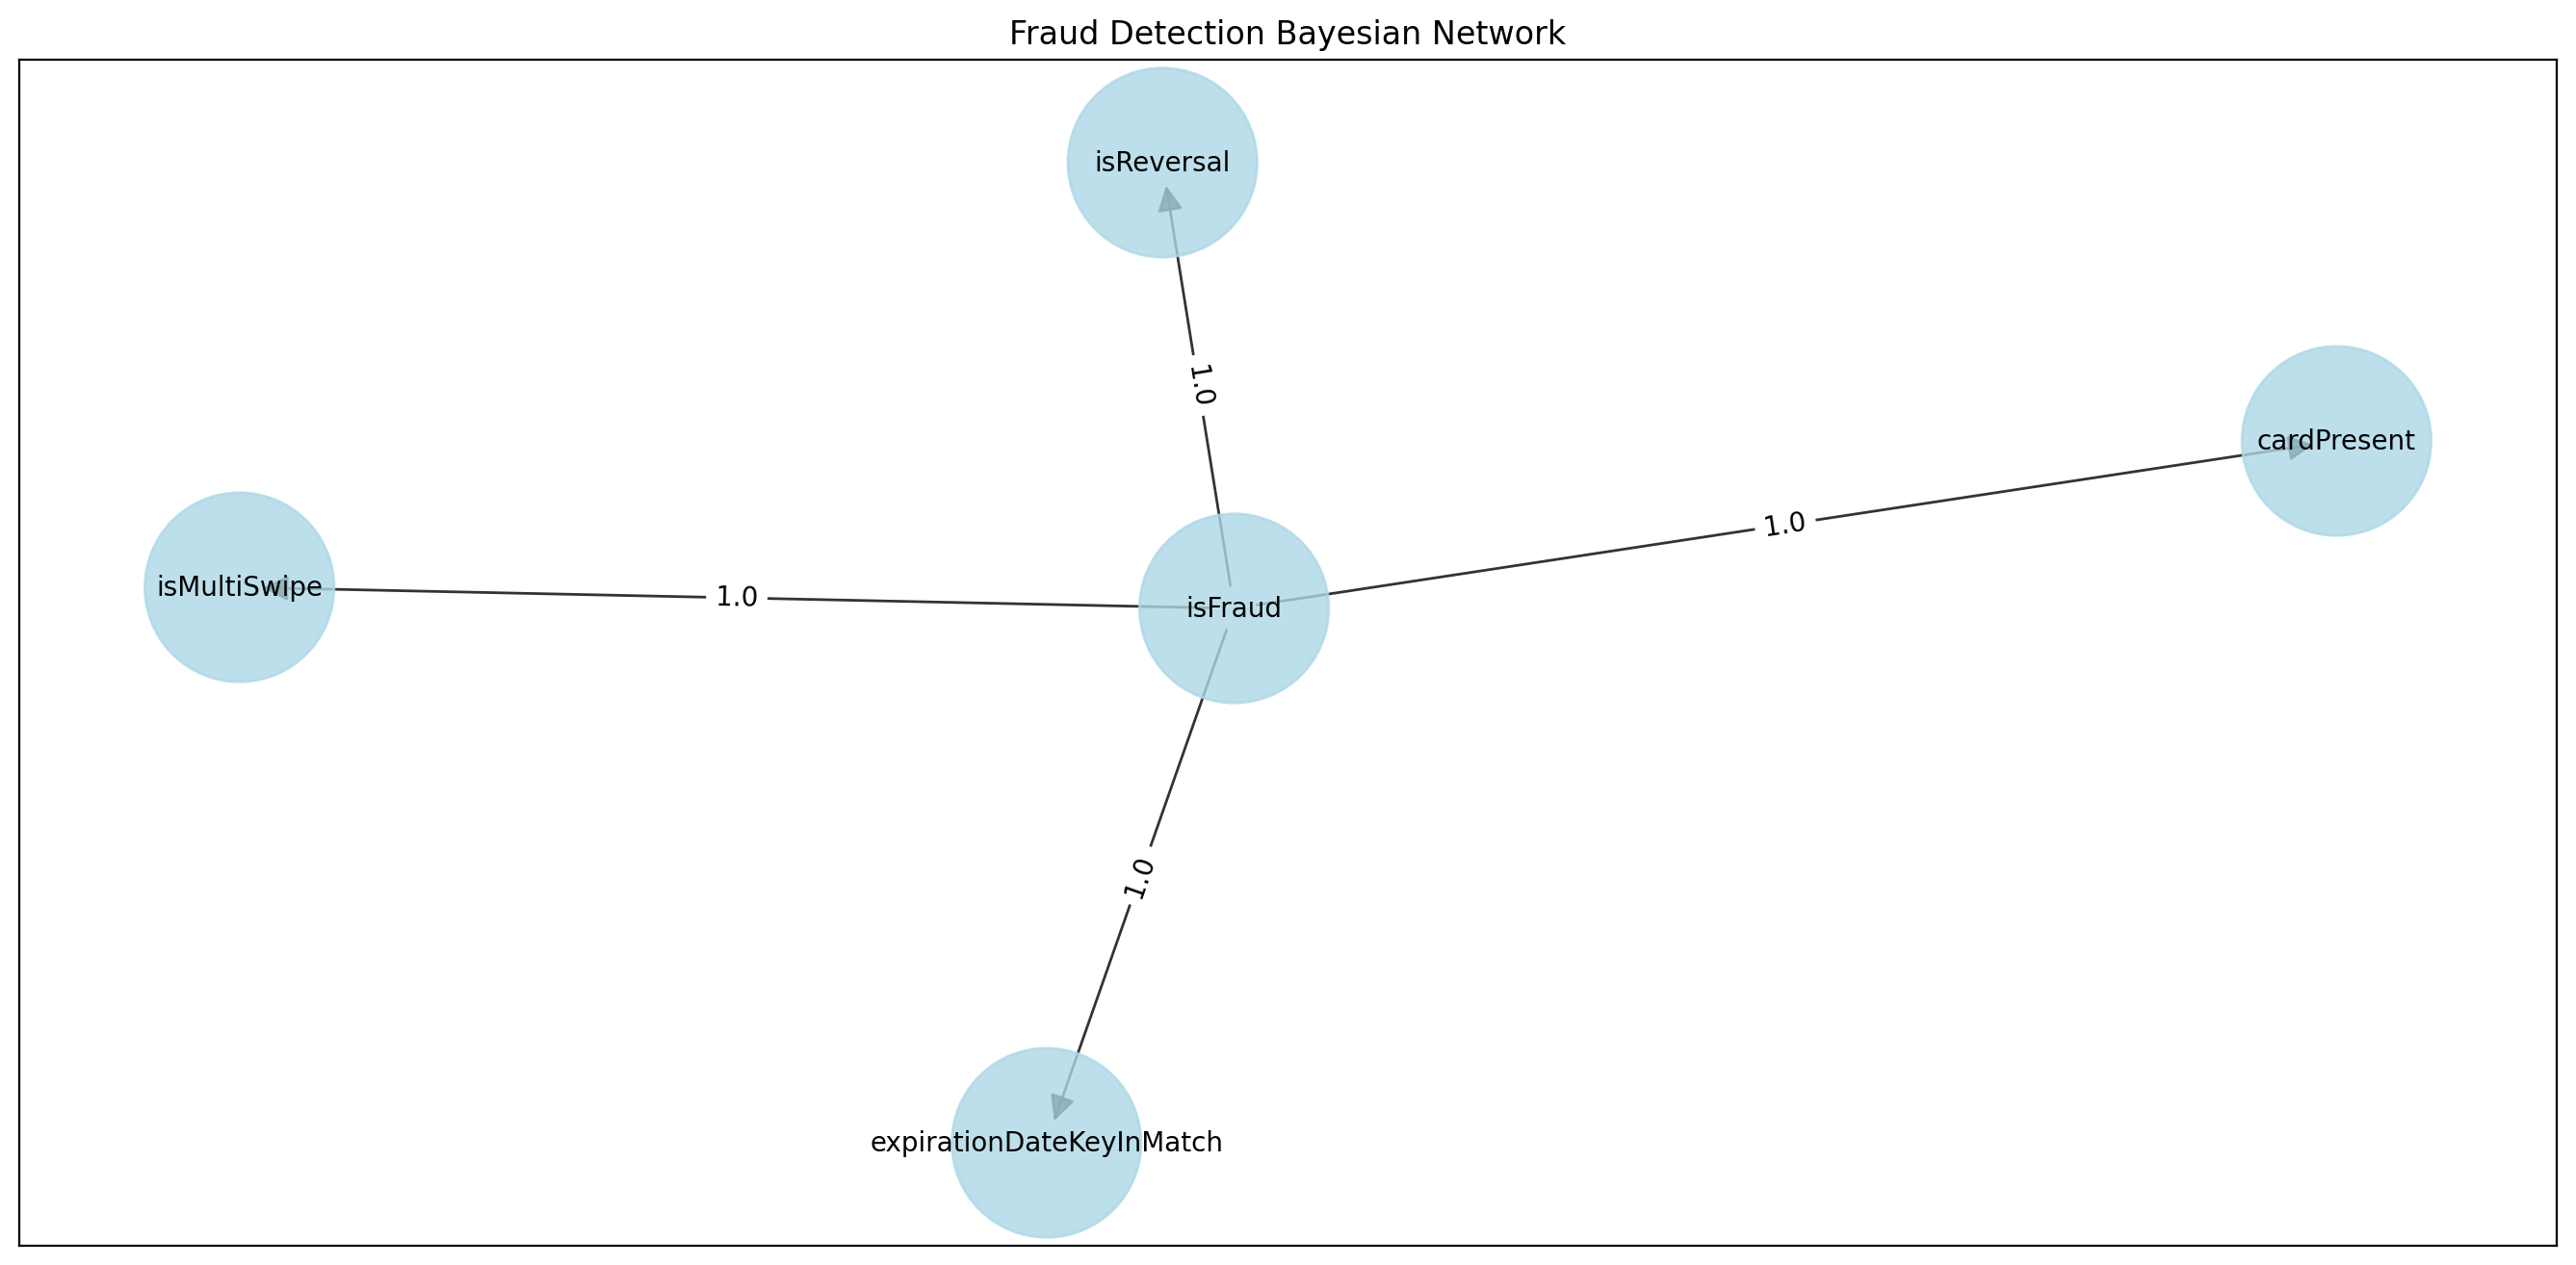

In [96]:
# Define the edges of the network and create the DAG
edges = [
    ("isFraud", var)
    for var in ["isReversal", "isMultiSwipe", "cardPresent", "expirationDateKeyInMatch"]
]
dag = bn.make_DAG(edges, methodtype="nb")
bn.plot(
    dag,
    params_static={"font_size": 10, "figsize": (17, 8)},
    node_color="lightblue",
    node_size=5000,
    title="Fraud Detection Bayesian Network",
);

The next step is to learn the parameters, i.e., the conditional probability distributions for all nodes, from the data using maximum likelihood and BIC scoring:

In [97]:
bn_data = (
    transaction_data.select(
        pl.col(
            [
                "accountNumber",
                "isFraud",
                "cardPresent",
                "expirationDateKeyInMatch",
                "isReversal",
                "isMultiSwipe",
            ]
        )
    )
    .drop(pl.col("accountNumber"))
    .to_pandas()
)
bn_data.head(5)

,isFraud,cardPresent,expirationDateKeyInMatch,isReversal,isMultiSwipe
0,False,True,False,False,None
1,False,True,False,False,False
2,False,False,False,False,False
3,False,True,False,False,False
4,False,True,False,False,False


In [98]:
nb_model = bn.parameter_learning.fit(
    model=dag,
    df=bn_data,
    methodtype="maximumlikelihood",
    scoretype="bic",
    n_jobs=-1,
    verbose=0,
)

# Check the model for CPD consistency
bn.check_model(nb_model, verbose=3)

[bnlearn] >Check whether CPDs sum up to one.


#### Bayesian Network Model Summary Table

To perform inference on the Bayesian Network model, we will use the variable elimination algorithm to calculate the marginal probability of `isFraud` given the evidence of the set of other binary features.

This allows us to effectively compute the marginal probability of fraud given the evidence, which can be:

* whether a transaction is a reversal or not

* whether a transaction is a multi-swipe or not

* whether a transaction is a card-present transaction or not

* whether the expiration date key is matched or not

In [99]:
vars = [col for col in bn_data.columns if col != "isFraud"]

# Container for the results
results = {
    "Variable": [],
    "P(Fraud = 1 | Variable = 0)": [],
    "P(Fraud = 1 | Variable = 1)": [],
}
for var in vars:
    # Probability of fraud when the evidence variable takes the value 0
    not_active = bn.inference.fit(
        model=nb_model, variables=["isFraud"], evidence={var: 0}, to_df=True, verbose=0
    ).df
    not_active_prob = not_active.loc[not_active["isFraud"] == 1, "p"].values[0]

    # Probability of fraud when the evidence variable takes the value 1
    active = bn.inference.fit(
        model=nb_model, variables=["isFraud"], evidence={var: 1}, to_df=True, verbose=0
    ).df
    active_prob = active.loc[active["isFraud"] == 1, "p"].values[0]

    # Append the results
    results["Variable"].append(var)
    results["P(Fraud = 1 | Variable = 0)"].append(not_active_prob)
    results["P(Fraud = 1 | Variable = 1)"].append(active_prob)

results = pl.from_dict(results)

results = results.with_columns(
    (
        (pl.col("P(Fraud = 1 | Variable = 1)") - pl.col("P(Fraud = 1 | Variable = 0)"))
        / pl.col("P(Fraud = 1 | Variable = 0)")
        * 100
    ).alias("Percentage Change (%)")
).to_pandas()

results = results.style.apply(
    lambda x: [
        "background: red"
        if x["Percentage Change (%)"] > 0
        else "background: green"
        if x["Percentage Change" " (%)"] < 0
        else ""
        for i in x
    ],
    axis=1,
)

results

,Variable,P(Fraud = 1 | Variable = 0),P(Fraud = 1 | Variable = 1),Percentage Change (%)
0,cardPresent,0.021398,0.009787,-54.263823
1,expirationDateKeyInMatch,0.016056,0.012464,-22.371050
2,isReversal,0.016039,0.017601,9.744402
3,isMultiSwipe,0.016042,0.017026,6.136919


- **Risk Factors** (highlighted in green):

  - Variables in this category increase the probability of fraud when their value is `true` or `1`.

    - `isReversal`: Reversed transactions are more likely to be fraudulent.

    - `isMultiswipe`: Multiple-swipe transactions are more likely to be fraudulent.

- **Mitigators** (highlighted in red):

  - Variables in this category decrease the probability of fraud when their value is `true` or `1`.

    - `cardPresent`: Fraud is less likely when the card is present at the point of sale.
    
    - `expirationDateKeyInMatch`: Fraud is less likely when the expiration date key matches.

## EDA Summary

Below we will list out the key findings from the exploratory data analysis:

<center>

| Name of Feature              | Data Type      | Group | Missing Values?       | High Cardinality (> 100 Unique Categories) | Is Target? |
|------------------------------|----------------|---------------------|-----------------------|-------------------------------------------|------------|
| accountNumber                | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| customerId                   | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| cardCVV                      | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| enteredCVV                   | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| cardLast4Digits              | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| merchantName                 | String         | Categorical         | No                    | <span style="background-color:red">Yes</span>                                       | No         |
| acqCountry                   | String         | Categorical         | <span style="background-color:red">Yes</span>     | No                                        | No         |
| merchantCountryCode          | String         | Categorical         | <span style="background-color:red">Yes</span>      | No                                        | No         |
| posEntryMode                 | String         | Categorical         | <span style="background-color:red">Yes</span>     | No                                        | No         |
| posConditionCode             | String         | Categorical         | <span style="background-color:red">Yes</span>      | No                                        | No         |
| transactionType              | String         | Categorical         | <span style="background-color:red">Yes</span>                    | No                                        | No         |
| merchantCategoryCode         | String         | Categorical         | No                    | No                                        | No         |
| cardPresent                  | Boolean        | Categorical         | No                    | No                                        | No         |
| expirationDateKeyInMatch     | Boolean        | Categorical         | No                    | No                                        | No         |
| isFraud                      | Boolean        | Categorical         | No                    | No                                        | <span style="background-color:green">Yes</span>        |
| creditLimit                  | Float32        | Numeric             | No                    | No                                        | No         |
| currentBalance               | Float32        | Numeric             | No      | No                                        | No         |
| availableMoney               | Float32        | Numeric             | No                    | No                                        | No         |
| transactionAmount            | Float32        | Numeric             | No                    | No                                        | No         |
| currentExpDate               | Date           | Date         | No                    | No                                        | No         |
| accountOpenDate              | Date           | Date         | No                    | No                                        | No         |
| dateOfLastAddressChange      | Date           | Date         | No                    | No                                        | No         |
| transactionDateTime          | DateTime       | DateTime             | No                    | No                                        | No         |

</center>